### Credit Card Fraud Detection System

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import early_stopping
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap
import joblib

In [3]:
# Readind the CSV file
df = pd.read_csv('creditcard.csv')

In [37]:
print(df.head())
print(df.shape)
print(df.info())

       Time         V1        V2         V3        V4         V5        V6  \
0   41505.0 -16.526507  8.584972 -18.649853  9.505594 -13.793819 -2.832404   
1   44261.0   0.339812 -2.743745  -0.134070 -1.385729  -1.451413  1.015887   
2   35484.0   1.399590 -0.590701   0.168619 -1.029950  -0.539806  0.040444   
3  167123.0  -0.432071  1.647895  -1.669361 -0.349504   0.785785 -0.630647   
4  168473.0   2.014160 -0.137394  -1.015839  0.327269  -0.182179 -0.956571   

          V7        V8        V9  ...       V24       V25       V26       V27  \
0 -16.701694  7.517344 -8.507059  ...  0.673461 -1.413700 -0.462762 -2.018575   
1  -0.524379  0.224060  0.899746  ... -1.156992  0.311211 -0.746647  0.040996   
2  -0.712567  0.002299 -0.971747  ... -0.810250  0.505083 -0.232340  0.011409   
3   0.276990  0.586025 -0.484715  ... -0.017171 -0.207392 -0.157756 -0.237386   
4   0.043241 -0.160746  0.363241  ...  0.061561 -0.360196  0.174730 -0.078043   

        V28  Amount  Log_Amount  Scaled_Amou

There are around 2,84,807 transactions

As seen from the info, the dataset does not contain any null values.
Another thing to be noticed is that **all the features** are **float**, except **Class** feature which would be our target variable in this scenario. It's data type is **int**.\
**Class = 0(Genuine) / 1(Fraudulent)**

### Check for Fraud vs Non-Fraud Transactions

Total Fraudulent Transactions : 492
Total Non-Fraudulent Transactions : 284315
Percentage of Fraudulent Transactions : 0.1727485630620034


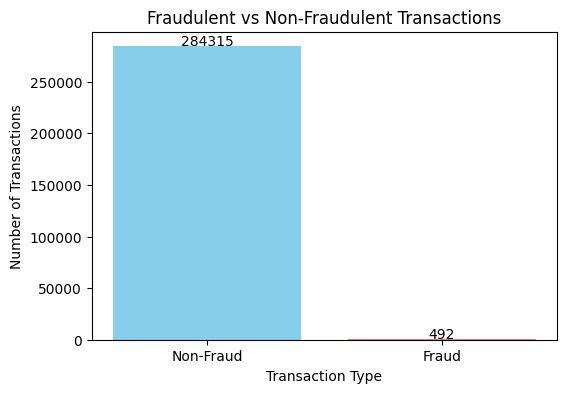

In [39]:
non_fraud, fraud = df['Class'].value_counts()
print(f'Total Fraudulent Transactions : {fraud}\nTotal Non-Fraudulent Transactions : {non_fraud}')

# Percentage of Fraudulent Transactions in the dataset
fraud_per = fraud/(fraud + non_fraud) * 100
print(f'Percentage of Fraudulent Transactions : {fraud_per}')

# Plot a bar chart to visualise class imbalance
counts = [non_fraud, fraud]
labels = ['Non-Fraud', 'Fraud']

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Transactions")

# To add numbers on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 1000, str(count), ha='center', fontsize=10)
    
plt.show()

Let's check other features and their distributions

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

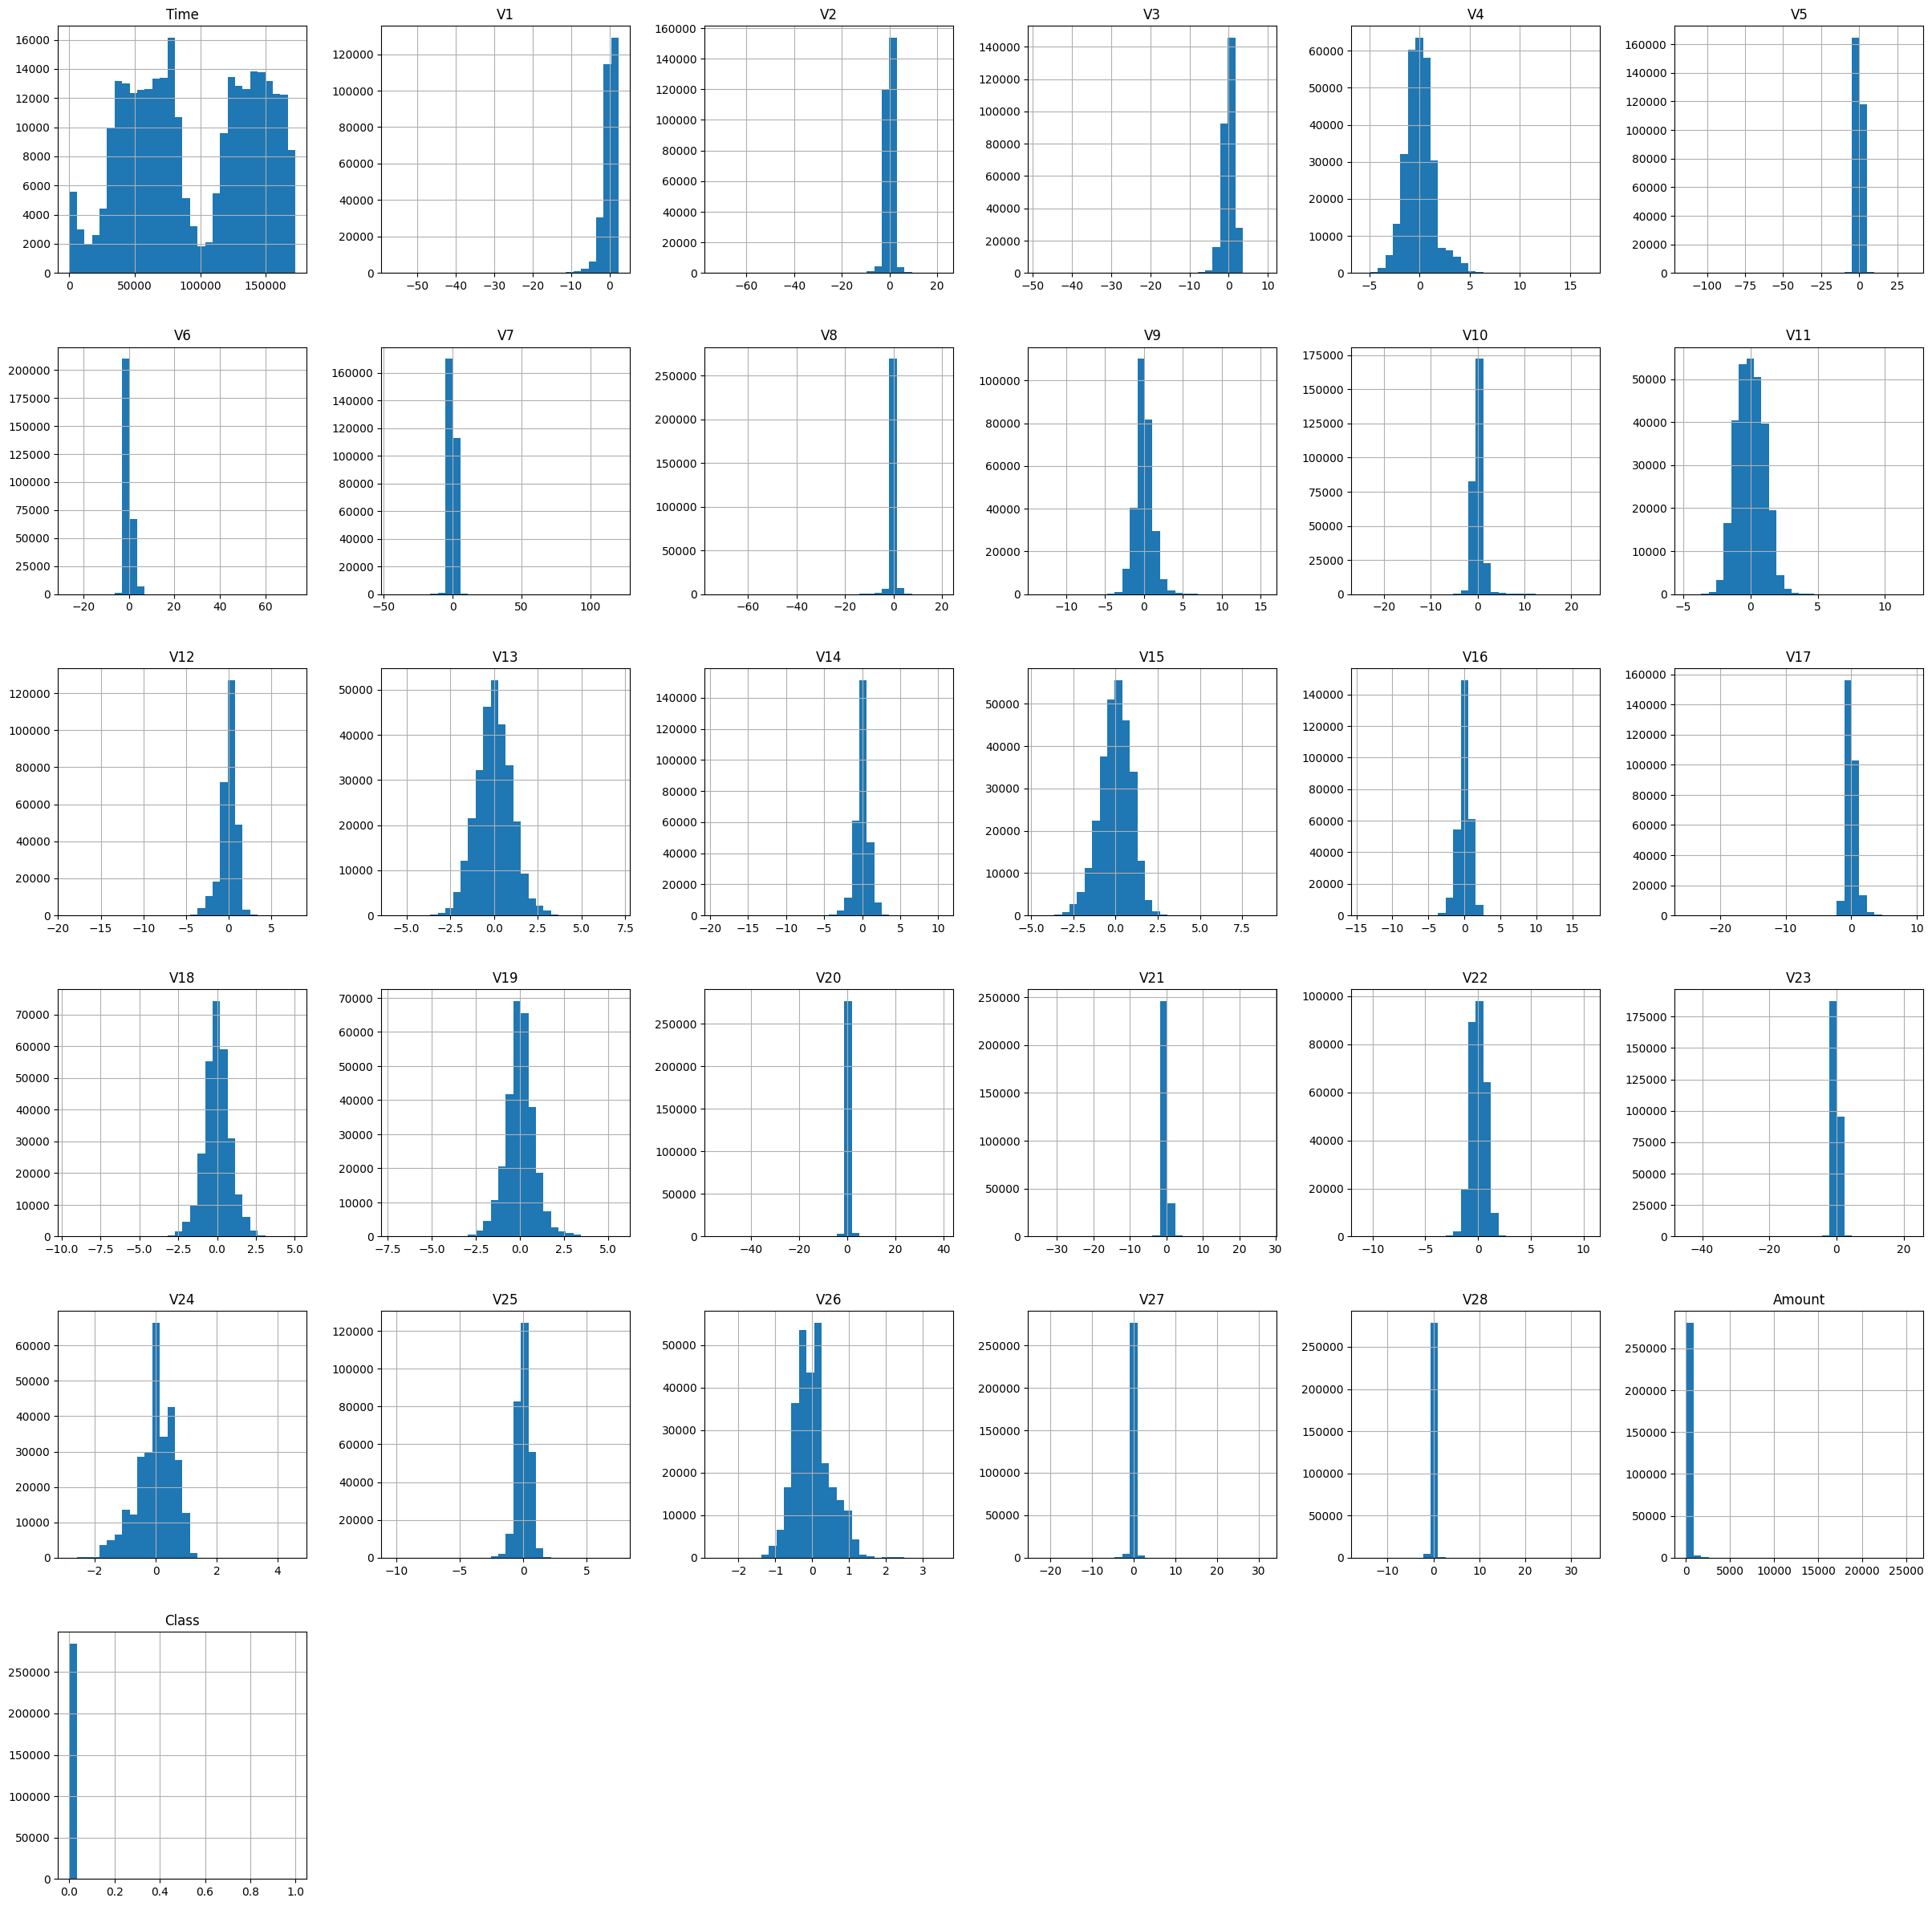

In [11]:
df.hist(bins = 30, figsize=(30, 30))

The ***Amount*** feature represents the transaction value in euros and is ***highly skewed***, with most transactions being small and a few extremely large outliers. To make the distribution more balanced and comparable with other features, we applied a ***log transformation*** using log(1 + Amount). This helps models better capture patterns across both small and large transactions.

### Data Preprocessing

In [40]:
# Log transformation
df['Log_Amount'] = np.log1p(df['Amount'])

# Robust Scaling
scaler = RobustScaler()
df['Scaled_Amount'] = scaler.fit_transform(df[['Log_Amount']])

scaler = StandardScaler()
# Scale the Time column
df['Scaled_Time'] = scaler.fit_transform(df[['Time']])

### Plotting Amount Distribution before and after robust scaling

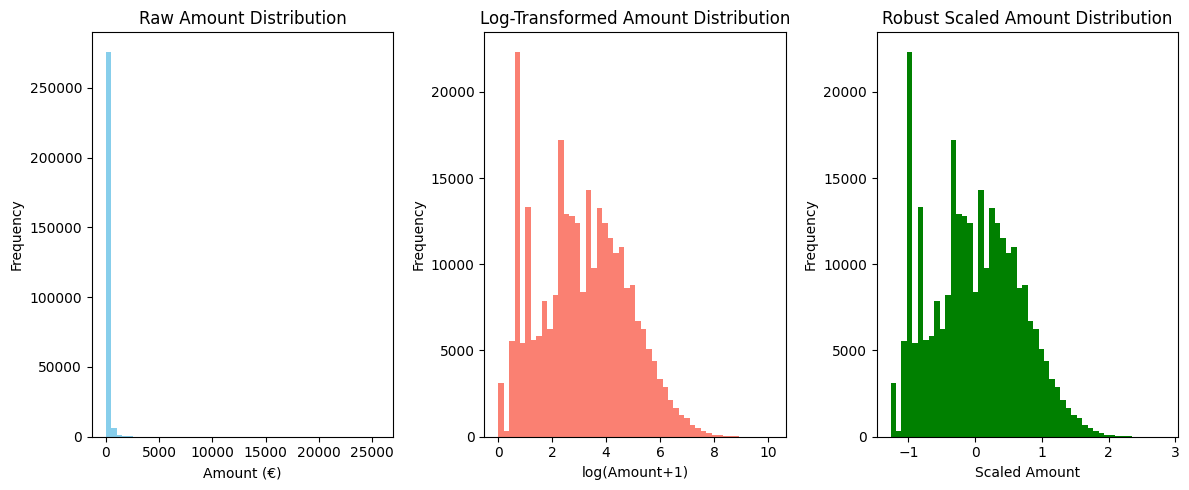

In [13]:
plt.figure(figsize=(12,5))

# Amount distribution
plt.subplot(1,3,1)
plt.hist(df['Amount'], bins=50, color='skyblue')
plt.title("Raw Amount Distribution")
plt.xlabel("Amount (€)")
plt.ylabel("Frequency")

# Log-transformed Amount distribution
plt.subplot(1,3,2)
plt.hist(df['Log_Amount'], bins=50, color='salmon')  
plt.title("Log-Transformed Amount Distribution")
plt.xlabel("log(Amount+1)")
plt.ylabel("Frequency")

# Robust Scaled Amount distribution
plt.subplot(1,3,3)
plt.hist(df['Scaled_Amount'], bins=50, color='green')  
plt.title("Robust Scaled Amount Distribution")
plt.xlabel("Scaled Amount")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
df['Scaled_Amount'].describe()

count    284807.000000
mean          0.006754
std           0.670232
min          -1.268531
25%          -0.505077
50%           0.000000
75%           0.494923
max           2.839462
Name: Scaled_Amount, dtype: float64

### Plotting Time Distribution before and after standard scaling

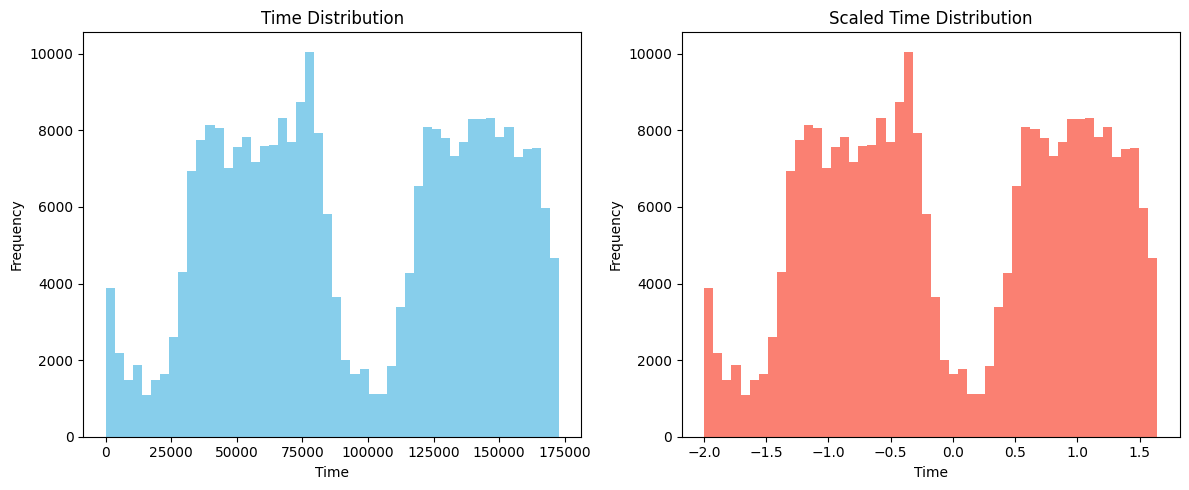

In [41]:
plt.figure(figsize=(12,5))

# Time distribution
plt.subplot(1,2,1)
plt.hist(df['Time'], bins=50, color='skyblue')
plt.title("Time Distribution")
plt.xlabel("Time")
plt.ylabel("Frequency")

# Standard Scaled Time distribution
plt.subplot(1,2,2)
plt.hist(df['Scaled_Time'], bins=50, color='salmon')  
plt.title("Scaled Time Distribution")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Now that we've scaled both ***Amount*** and ***Time***, let's move on to modelling step.

### Ways to Handle Class Imbalance

#### 1. Data-Level Methods
- **Undersampling majority (0’s)**: reduce the number of non-fraud transactions.  
- **Oversampling minority (1’s)**: duplicate fraud transactions to balance classes.  
- **SMOTE**: create synthetic fraud cases for more variety instead of simple oversampling.  

#### 2. Algorithm-Level Methods
- **Class weights**: give more importance to fraud cases.  
  - Example: `class_weight='balanced'` in Logistic Regression or Random Forest.  
  - Example: `scale_pos_weight` in XGBoost.  

#### 3. Evaluation Metric Choice
- **Precision**: how many flagged frauds are real frauds.  
- **Recall**: how many actual frauds we caught.  
- **F1-score**: balance between precision and recall.  
- **ROC-AUC / PR-AUC**: PR-AUC is especially important under extreme imbalance.  


### Resampling

In [42]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [43]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Log_Amount,Scaled_Amount,Scaled_Time,Class
0,72711.0,1.178598,0.165963,0.121668,1.092826,0.039454,-0.102678,0.035372,0.000913,0.106360,...,-0.462839,0.643265,-0.218767,0.025268,0.016461,29.99,3.433665,0.120631,-0.465440,0
1,57164.0,-0.754196,0.816714,1.900594,-0.204846,0.258701,-0.183295,0.847090,-0.008486,-0.600570,...,0.252736,0.403427,0.530817,0.080610,-0.116282,20.62,3.073619,-0.025033,-0.792828,0
2,157256.0,-0.613051,0.984764,-0.090300,-0.795440,2.018146,-0.217026,1.562558,-0.253562,-1.155665,...,-1.294652,1.493782,0.198222,-0.020264,0.014614,13.23,2.655352,-0.194252,1.314902,0
3,39509.0,1.154826,0.166233,0.593458,0.502893,-0.315514,-0.307808,-0.093892,0.052094,-0.270624,...,0.225906,0.094777,0.093054,-0.014995,0.008507,4.49,1.702928,-0.579575,-1.164606,0
4,72427.0,-0.252670,1.023347,1.304723,0.411112,0.303165,-0.424341,0.591484,-0.022438,-0.676465,...,0.051479,-0.789975,0.115854,0.156781,0.172765,0.99,0.688135,-0.990131,-0.471421,0


In [44]:
df.shape

(284807, 34)

In [45]:
cols = [c for c in df.columns if c != 'Class'] + ['Class']
df = df[cols]
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Log_Amount,Scaled_Amount,Scaled_Time,Class
0,72711.0,1.178598,0.165963,0.121668,1.092826,0.039454,-0.102678,0.035372,0.000913,0.106360,...,-0.462839,0.643265,-0.218767,0.025268,0.016461,29.99,3.433665,0.120631,-0.465440,0
1,57164.0,-0.754196,0.816714,1.900594,-0.204846,0.258701,-0.183295,0.847090,-0.008486,-0.600570,...,0.252736,0.403427,0.530817,0.080610,-0.116282,20.62,3.073619,-0.025033,-0.792828,0
2,157256.0,-0.613051,0.984764,-0.090300,-0.795440,2.018146,-0.217026,1.562558,-0.253562,-1.155665,...,-1.294652,1.493782,0.198222,-0.020264,0.014614,13.23,2.655352,-0.194252,1.314902,0
3,39509.0,1.154826,0.166233,0.593458,0.502893,-0.315514,-0.307808,-0.093892,0.052094,-0.270624,...,0.225906,0.094777,0.093054,-0.014995,0.008507,4.49,1.702928,-0.579575,-1.164606,0
4,72427.0,-0.252670,1.023347,1.304723,0.411112,0.303165,-0.424341,0.591484,-0.022438,-0.676465,...,0.051479,-0.789975,0.115854,0.156781,0.172765,0.99,0.688135,-0.990131,-0.471421,0


### Splitting the dataset into training, testing and validation sets

In [46]:
train, test, val = df[:240000], df[240000:262000], df[262000:]

print(train['Class'].value_counts())
print(test['Class'].value_counts())
print(val['Class'].value_counts())

Class
0    239586
1       414
Name: count, dtype: int64
Class
0    21967
1       33
Name: count, dtype: int64
Class
0    22762
1       45
Name: count, dtype: int64


In [47]:
train_np, test_np, val_np = train.to_numpy(), test.to_numpy(), val.to_numpy()

### Splitting features and target variable

In [48]:
X_train, y_train = train_np[:, :-1], train_np[:, -1]
X_test, y_test = test_np[:, :-1], test_np[:, -1]
X_val, y_val = val_np[:, :-1], val_np[:, -1]

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((240000, 33), (240000,), (22000, 33), (22000,), (22807, 33), (22807,))

### Modelling

***Logistic Regression***

In [50]:
# instantiate the model (using the default parameters) and class weights
weights = {0: 1, 1: 10}
logreg = LogisticRegression(random_state=16, class_weight=weights)

# fit the model with data
logreg.fit(X_train, y_train)

logreg.score(X_train, y_train)

print(classification_report(y_val, logreg.predict(X_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       0.89      0.87      0.88        45

    accuracy                           1.00     22807
   macro avg       0.94      0.93      0.94     22807
weighted avg       1.00      1.00      1.00     22807



C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Random Forest Classifier***

In [51]:
rf_model = RandomForestClassifier(
    n_estimators=100,           # number of trees
    class_weight='balanced',    # automatically adjusts weights inversely proportional to class frequencies
    random_state=42,
    max_depth=10,               # prevent overfitting
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1                   # use all CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)

print(classification_report(y_val, rf_model.predict(X_val), target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       0.93      0.87      0.90        45

    accuracy                           1.00     22807
   macro avg       0.96      0.93      0.95     22807
weighted avg       1.00      1.00      1.00     22807



***Calculate scale_pos_weight***

In [52]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale = neg_count / pos_count
print(scale)

578.7101449275362


***LightGBM Classifier***

In [54]:
# LightGBM supports native imbalance with 'is_unbalance' or scale_pos_weight
lgbm_clf = lgb.LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale,   # calculated ratio
    max_depth=10,
    min_child_samples=50,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.1,
    n_estimators=500,
    reg_alpha=0.1,        # L1 regularisation helps reduce complexity
    reg_lambda=0.1,
    random_state=42
)

lgbm_clf.fit(X_train, y_train)

# Validation predictions
y_pred = lgbm_clf.predict(X_val)
y_probs_lgbm = lgbm_clf.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))

[LightGBM] [Info] Number of positive: 414, number of negative: 239586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360802
[LightGBM] [Info] Start training from score -6.360802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       0.60      0.89      0.71        45

    accuracy                           1.00     22807
   macro avg       0.80      0.94      0.86     22807
weighted avg       1.00      1.00      1.00     22807



***XGBoost Classifier***

In [61]:
# Define model
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale,
    random_state=42,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

# Fit model
xgb_clf.fit(X_train, y_train)

y_probs_xgb = xgb_clf.predict_proba(X_val)[:, 1]
print(classification_report(y_val, xgb_clf.predict(X_val), target_names=['Not Fraud', 'Fraud']))

C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:48:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       1.00      0.91      0.95        45

    accuracy                           1.00     22807
   macro avg       1.00      0.96      0.98     22807
weighted avg       1.00      1.00      1.00     22807



### Hyperparameter Tuning using GridSearchCV

In [53]:
xgbm = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)

# Keep the grid tiny for speed (2 values each, 32 fits for 5 params)
param_grid = {
    'max_depth': [8, 10],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [500, 1000],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
}

grid_search = GridSearchCV(
    estimator=xgbm,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_val)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:42:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.8}
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22768
       Fraud       0.97      0.85      0.90        39

    accuracy                           1.00     22807
   macro avg       0.99      0.92      0.95     22807
weighted avg       1.00      1.00      1.00     22807



***CatBoost***

In [63]:
cat_clf = CatBoostClassifier(
    iterations=500,           # Number of boosting rounds (trees)
    learning_rate=0.1,        # Default step size
    depth=8,                  # Tree depth
    scale_pos_weight=scale,   # Address class imbalance (same as XGBoost/LightGBM)
    eval_metric='F1',         # Optimise for F1 on validation set
    random_state=42,
    verbose=0                 # Silent by default, change to True for progress
)

cat_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = cat_clf.predict(X_val)
y_probs_cat = cat_clf.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       0.91      0.91      0.91        45

    accuracy                           1.00     22807
   macro avg       0.96      0.96      0.96     22807
weighted avg       1.00      1.00      1.00     22807



***Neural Network***

In [57]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    batch_size=256,
    max_iter=20,
    random_state=42,
    early_stopping=True,
    verbose=True
)

mlp.fit(X_train, y_train)
y_probs_mlp = mlp.predict_proba(X_val)[:, 1]

print(classification_report(y_val, mlp.predict(X_val), target_names=['Not Fraud', 'Fraud']))

Iteration 1, loss = 0.34938502
Validation score: 0.998292
Iteration 2, loss = 0.06298584
Validation score: 0.998333
Iteration 3, loss = 0.08388069
Validation score: 0.998292
Iteration 4, loss = 0.06028458
Validation score: 0.997875
Iteration 5, loss = 0.07472226
Validation score: 0.998292
Iteration 6, loss = 0.09901473
Validation score: 0.998292
Iteration 7, loss = 0.07516528
Validation score: 0.998250
Iteration 8, loss = 0.06979415
Validation score: 0.998250
Iteration 9, loss = 0.09108975
Validation score: 0.998292
Iteration 10, loss = 0.06109086
Validation score: 0.998042
Iteration 11, loss = 0.05392704
Validation score: 0.997792
Iteration 12, loss = 0.05756786
Validation score: 0.998292
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       0.45      0.11      0.18        45

    accuracy                           1.00 

***Voting Ensemble***

In [58]:
from sklearn.ensemble import VotingClassifier

xgb_clf = xgb.XGBClassifier(
    n_estimators=500, max_depth=10, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale, random_state=42,
    use_label_encoder=False, eval_metric='logloss'
)

lgbm_clf = lgb.LGBMClassifier(
    n_estimators=500, max_depth=10, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale, reg_alpha=0.1, reg_lambda=0.1,
    random_state=42
)

cat_clf = CatBoostClassifier(
    iterations=500, learning_rate=0.1, depth=8,
    scale_pos_weight=scale, eval_metric='F1',
    random_state=42, verbose=0
)

rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32), activation='relu',
    solver='adam', alpha=1e-3, batch_size=256,
    max_iter=20, random_state=42,
    early_stopping=True, verbose=True
)

ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('lgbm', lgbm_clf),
        ('cat', cat_clf),
        ('mlp', mlp_clf),
        ('rf', rf_clf)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
y_probs_ensemble = ensemble.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))

C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sanyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22762
       Fraud       1.00      0.87      0.93        45

    accuracy                           1.00     22807
   macro avg       1.00      0.93      0.96     22807
weighted avg       1.00      1.00      1.00     22807



In [59]:
# Calculate AUPRC for each model
ap_xgb = average_precision_score(y_val, y_probs_xgb)
ap_lgbm = average_precision_score(y_val, y_probs_lgbm)
ap_cat = average_precision_score(y_val, y_probs_cat)
ap_ensemble = average_precision_score(y_val, y_probs_ensemble)

print(f"AUPRC XGBoost: {ap_xgb:.4f}")
print(f"AUPRC LightGBM: {ap_lgbm:.4f}")
print(f"AUPRC CatBoost: {ap_cat:.4f}")
print(f"AUPRC Ensemble: {ap_ensemble:.4f}")

AUPRC XGBoost: 0.9405
AUPRC LightGBM: 0.5309
AUPRC CatBoost: 0.9480
AUPRC Ensemble: 0.9396


### Evaluation on Test Set

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     21967
       Fraud       0.71      0.73      0.72        33

    accuracy                           1.00     22000
   macro avg       0.85      0.86      0.86     22000
weighted avg       1.00      1.00      1.00     22000

Confusion matrix:
 [[21957    10]
 [    9    24]]
ROC-AUC: 0.9561
Average Precision (PR-AUC): 0.7148


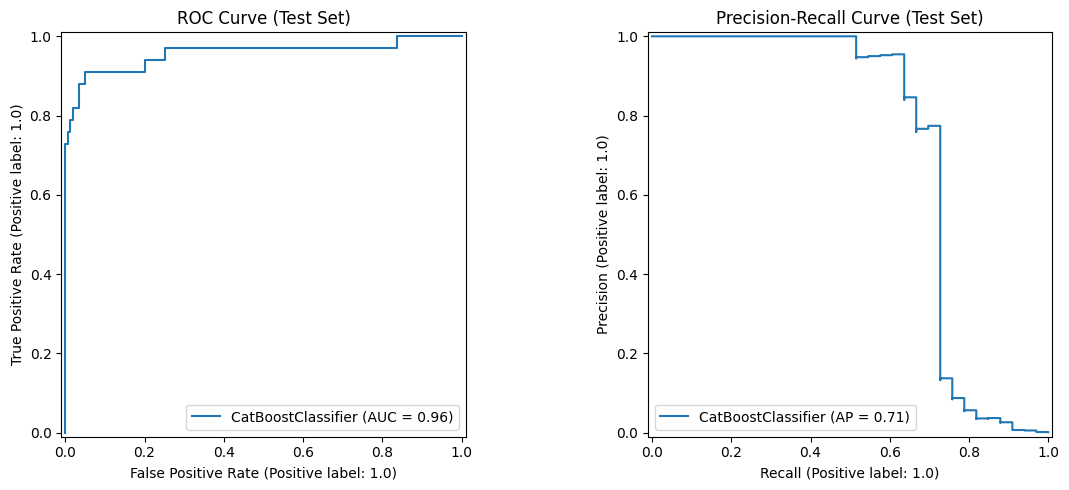

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

# Predict and probability on test
y_pred = cat_clf.predict(X_test)
y_prob = cat_clf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# Confusion matrix
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# Average precision (AUC-PR)
ap = average_precision_score(y_test, y_prob)
print(f"Average Precision (PR-AUC): {ap:.4f}")

# Optional: Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_estimator(cat_clf, X_test, y_test, ax=axes[0])
axes[0].set_title("ROC Curve (Test Set)")
PrecisionRecallDisplay.from_estimator(cat_clf, X_test, y_test, ax=axes[1])
axes[1].set_title("Precision-Recall Curve (Test Set)")
plt.tight_layout()
plt.show()

### Checking Feature Importance using SHAP

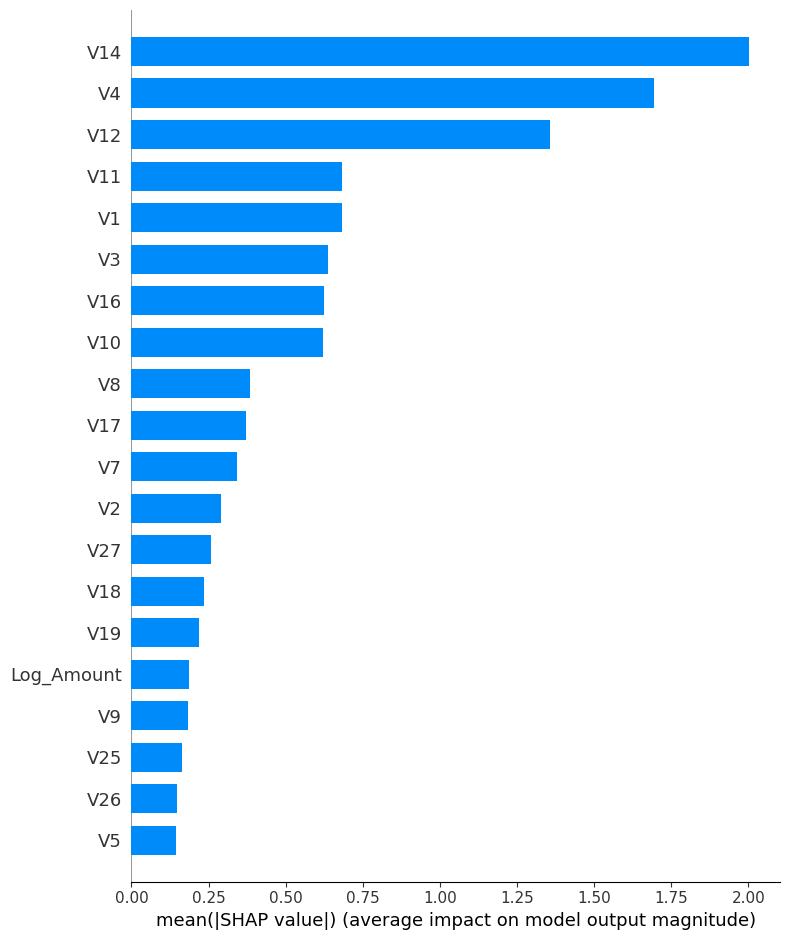

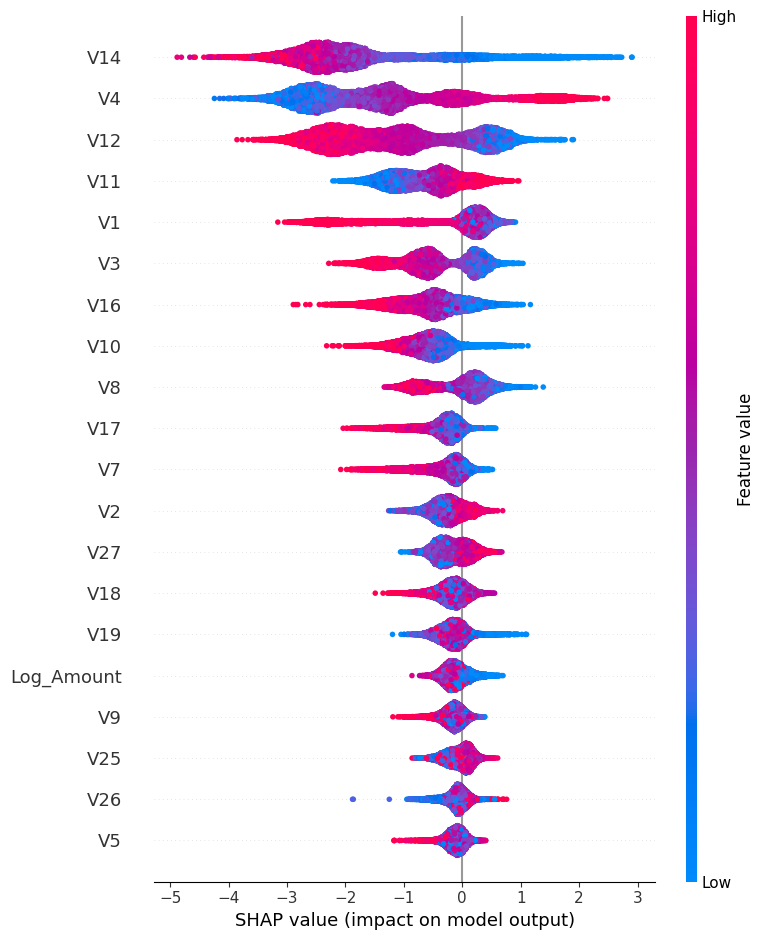

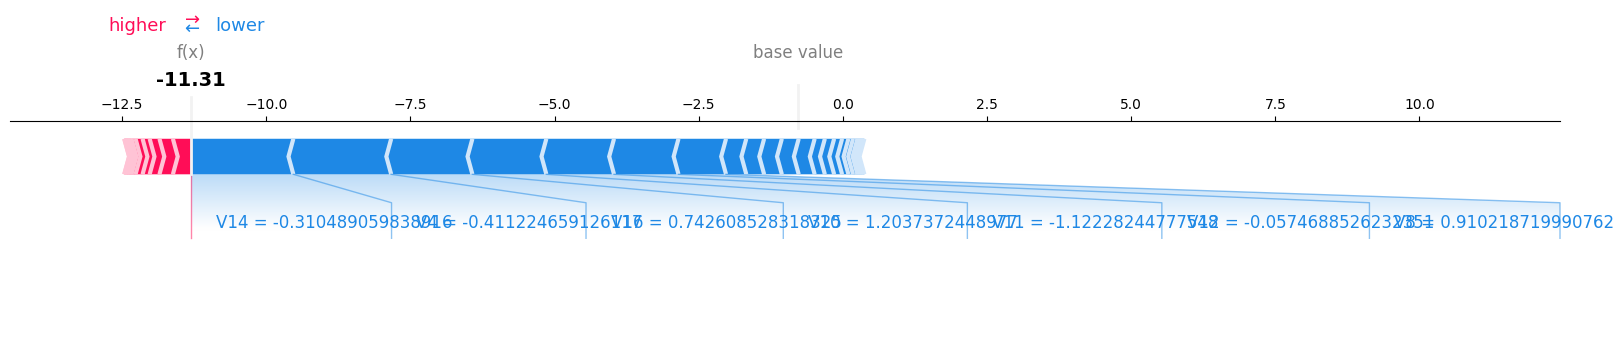

In [65]:
# If X_train is numpy array, convert it back to DataFrame with column names from original dataframe df
# Otherwise if you still have df or X_train as DataFrame, use those column names
feature_names = df.drop(columns=['Class']).columns.tolist()

# Convert X_test numpy array to DataFrame with correct column names
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    X_test_df = X_test

# Initialize SHAP TreeExplainer with the trained Cat Boost model
explainer = shap.TreeExplainer(cat_clf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# Global summary bar plot for feature importance
shap.summary_plot(shap_values, X_test_df, plot_type='bar')

# Detailed SHAP summary dot plot
shap.summary_plot(shap_values, X_test_df)

# Local explanation (force plot) for single instance (index 10)
idx = 10
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_test_df.iloc[idx, :], matplotlib=True)
plt.show()


### Saving the pipeline

In [66]:
# Log transformation function for Amount
def log_transform_amount(x):
    return np.log1p(x)

# Shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split df into train, test, val by indices keeping DataFrame structure
train = df.iloc[:240000]
test = df.iloc[240000:262000]
val = df.iloc[262000:]

# Separate features and labels using DataFrame operations to keep column names
X_train, y_train = train.drop(columns=['Class']), train['Class']
X_test, y_test = test.drop(columns=['Class']), test['Class']
X_val, y_val = val.drop(columns=['Class']), val['Class']

# Define columns by name as before
amount_col = ['Amount']
time_col = ['Time']
pca_cols = [f'V{i}' for i in range(1, 29)]

# Preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('log_amount', Pipeline([
        ('log', FunctionTransformer(log_transform_amount)),
        ('robust_scale', RobustScaler())
    ]), amount_col),
    ('scale_time', StandardScaler(), time_col),
    ('passthrough_pca', 'passthrough', pca_cols)
])

# Define full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('cat', cat_clf)  # your trained Cat Boost classifier
])

# Fit the pipeline on training data (with column names)
pipeline.fit(X_train, y_train)

# Save pipeline for later use
joblib.dump(pipeline, 'fraud_detection_pipeline.joblib')
print("Saved pipeline with preprocessing and model as 'fraud_detection_pipeline.joblib'")

Saved pipeline with preprocessing and model as 'fraud_detection_pipeline.joblib'


In [67]:
p_line = joblib.load('fraud_detection_pipeline.joblib')
print("Pipeline loaded successfully")

Pipeline loaded successfully


In [68]:
sample_transaction = pd.DataFrame({
    'Amount': [100.0],
    'Time': [20000],
    'V1': [0.1],
    'V2': [-1.2],
    'V3': [0.3],
    'V4': [0.5],
    'V5': [-0.1],
    'V6': [1.0],
    'V7': [-0.5],
    'V8': [0.2],
    'V9': [0.0],
    'V10': [-0.3],
    'V11': [0.7],
    'V12': [0.1],
    'V13': [-0.4],
    'V14': [0.2],
    'V15': [0.0],
    'V16': [0.6],
    'V17': [-0.1],
    'V18': [0.5],
    'V19': [0.4],
    'V20': [-0.2],
    'V21': [0.3],
    'V22': [-0.3],
    'V23': [0.1],
    'V24': [-0.5],
    'V25': [0.2],
    'V26': [-0.4],
    'V27': [0.0],
    'V28': [0.1]
})

# Predict using the pipeline on new data
pred_class = pipeline.predict(sample_transaction)[0]
pred_prob = pipeline.predict_proba(sample_transaction)[0, 1]

print(f"Predicted Class: {'Fraud' if pred_class == 1 else 'Not Fraud'}")
print(f"Fraud Probability: {pred_prob:.4f}")

Predicted Class: Not Fraud
Fraud Probability: 0.0000


In [65]:
import pandas as pd

fraud_transaction = pd.DataFrame({
    'Amount': [2000.0],           # large amount (usually fraud)
    'Time': [50000],              # transaction time
    'V1': [-3.5],
    'V2': [6.1],
    'V3': [0.45],
    'V4': [-2.4],
    'V5': [3.7],
    'V6': [1.2],
    'V7': [-3.1],
    'V8': [2.9],
    'V9': [-1.4],
    'V10': [1.5],
    'V11': [-2.1],
    'V12': [0.5],
    'V13': [1.2],
    'V14': [-1.0],
    'V15': [-1.7],
    'V16': [0.2],
    'V17': [1.6],
    'V18': [-3.9],
    'V19': [0.4],
    'V20': [-1.2],
    'V21': [-0.6],
    'V22': [1.3],
    'V23': [-0.1],
    'V24': [1.1],
    'V25': [-0.7],
    'V26': [0.6],
    'V27': [-0.8],
    'V28': [0.3]
})

pred_class = pipeline.predict(fraud_transaction)[0]
pred_prob = pipeline.predict_proba(fraud_transaction)[0, 1]

print(f"Predicted Class: {'Fraud' if pred_class == 1 else 'Not Fraud'}")
print(f"Fraud Probability: {pred_prob:.4f}")

Predicted Class: Not Fraud
Fraud Probability: 0.0000
